# Quantum Finance

## Quantum Amplitude Estimation

Given an operator $\mathcal{A}$ that acts as :    

$$ \mathcal{A}|0\rangle = \sqrt{1 - a}|\Psi_0\rangle + \sqrt{a}|\Psi_1\rangle $$

Quantum Amplitude Estimation (QAE) is the task of finding an estimate for the amplitude $a$ of the state $|\Psi_1\rangle$ :

$$ a = |\langle\Psi_1 | \Psi_1\rangle|^2.$$



The work was first investigated by [Brassard et al](https://arxiv.org/abs/quant-ph/0005055) in 2000 and their algorithm uses a combination of the Grover operator:

$$ \mathcal{Q} = \mathcal{A}\mathcal{S}_0\mathcal{A}^\dagger\mathcal{S}_{\Psi_1} $$

where $ \mathcal{S}_0$ and $\mathcal{S}_{\Psi_1}$ are reflections about the $|0\rangle $ and $|\Psi_{1}⟩$ states, respectively and Phase estimation. 

-------

This algorithm is computationally expensive and have large circuits, however there are other variants to this.



--------




## Example : 

We take $\mathcal{A}$ as a Bernoulli random variable with an unknown success probability $p$: 

$$ \mathcal{A}|0\rangle = \sqrt{1 - p}|0\rangle + \sqrt{p}|1\rangle. $$

On a quantum computer, we can model this operator with a rotation around the $Y-$ axis of a single qubit

$$ \mathcal{A} = R_Y(\theta_p), \theta_p = 2\sin^{-1}(\sqrt{p}). $$

The Grover operator for this case is particulary simple 

$$ \mathcal{Q} = R_Y(2\theta_p), $$

whose powers are very easy to calculate $ \mathcal{Q}^k = R_Y(2k\theta_p) $

-----

We'll fix the probability we want to estimate to $p = 0.2$

In [ ]:
!pip install qiskit

In [2]:
p = 0.2

Define the operator $\mathcal{A}$ and $\mathcal{Q}$

In [3]:
import numpy as np
from qiskit.circuit import QuantumCircuit


class BernoulliA(QuantumCircuit):

  """ A Circuit that will represent the A operator """

  def __init__(self, probability):
    super().__init__(1) # the circuit on 1 qubit
    theta_p = 2 * np.arcsin(np.sqrt(probability))
    self.ry(theta_p,0)


class BernoulliQ(QuantumCircuit):
  """ A class rep the Q operator """
  def __init__(self, probability):
    super().__init__(1)


    self._theta_p = 2 * np.arcsin(np.sqrt(probability))
    self.ry(2 * self._theta_p, 0)

  def power(self,k):
    # implement the power of Q
    q_k = QuantumCircuit(1)
    q_k.ry(2 * k * self._theta_p,0)
    return q_k


In [4]:
A = BernoulliA(p)
Q = BernoulliQ(p)

# The qiskit Amplitude Estimation Workflow

We can implement several QAE algoruthms that all derive from the `AmplitudeEstimator` interface. In the initializer we specify algorithm specific settings and the `estimate` method which does all the work, takes an `EstimationProblem` as input and returns an `AmplitudeEstimationResult` object. Since all QAE variants follow the same interface, we can use them all to solve the same problem instance.


In [5]:
from qiskit.algorithms import EstimationProblem

problem = EstimationProblem(state_preparation = A,
                            grover_operator = Q,
                            objective_qubits=[0])  # the good state Psi1 is identified as measuring |1> in qubit 0

Execute on Qiskit Statevector

In [6]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance

backend = BasicAer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend)

## Canonical Amplitude Estimation

Let's solve with the original QAE

In [7]:
from qiskit.algorithms import AmplitudeEstimation

ae = AmplitudeEstimation(
    num_eval_qubits=3,  # the number of evaluation qubits specifies circuit width and accuracy
    quantum_instance=quantum_instance,
)

With the algorithm defined, we can call the `estimate` method and provide it with problem to solve

In [8]:
ae_result = ae.estimate(problem)

In [9]:
print(ae_result.estimation)

0.1464466


We see that this is not a very good estimate for our target of $p = 0.2$ That’s due to the fact the canonical AE is restricted to a discrete grid, specified by the number of evaluation qubits:

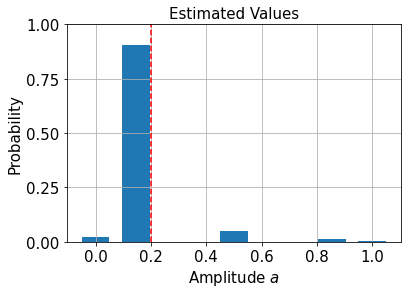

In [10]:
import matplotlib.pyplot as plt

# plot estimated values
gridpoints = list(ae_result.samples.keys())
probabilities = list(ae_result.samples.values())

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(p, color="r", ls="--")
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title("Estimated Values", size=15)
plt.ylabel("Probability", size=15)
plt.xlabel(r"Amplitude $a$", size=15)
plt.ylim((0, 1))
plt.grid()
plt.show()

To improve the estimate we can interpolate the measurement probabilities and compute the maximum likelihood estimator that produces this probability distribution:



In [11]:
print("Interpolated MLE estimator:", ae_result.mle)

Interpolated MLE estimator: 0.19999999390907777


## The circuit

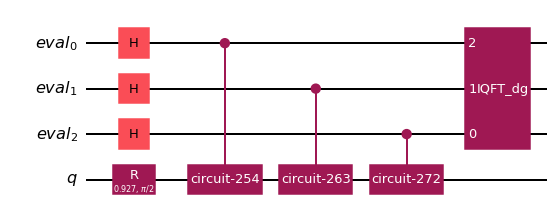

In [12]:
ae_circuit = ae.construct_circuit(problem)
ae_circuit.decompose().draw(
    "mpl", style="iqx"
)  # decompose 1 level: exposes the Phase estimation circuit!

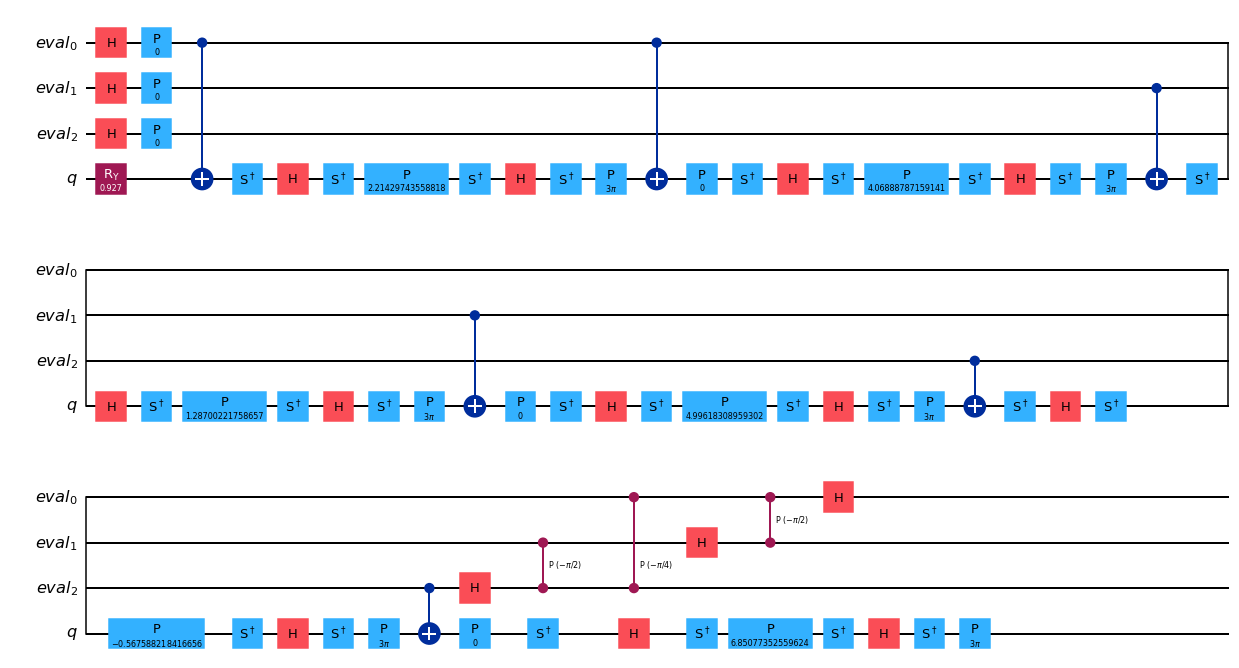

In [13]:
from qiskit import transpile


basis_gates = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
transpile(ae_circuit, basis_gates=basis_gates, optimization_level=2).draw("mpl", style="iqx")

## Iterative Amplitude Estimation

In [14]:
from qiskit.algorithms import IterativeAmplitudeEstimation

iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    quantum_instance=quantum_instance,
)
iae_result = iae.estimate(problem)

print("Estimate:", iae_result.estimation)

Estimate: 0.19999999999999998


The circuits here only consist of Grover powers and are much cheaper!

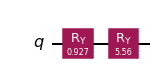

In [15]:
iae_circuit = iae.construct_circuit(problem, k=3)
iae_circuit.draw("mpl", style="iqx")

## Maximum Likelihood Amplitude Estimation

In [16]:
from qiskit.algorithms import MaximumLikelihoodAmplitudeEstimation

mlae = MaximumLikelihoodAmplitudeEstimation(
    evaluation_schedule=3, quantum_instance=quantum_instance  # log2 of the maximal Grover power
)
mlae_result = mlae.estimate(problem)

print("Estimate:", mlae_result.estimation)

Estimate: 0.20002237175368104


## Faster Amplitude Estimation

In [17]:
from qiskit.algorithms import FasterAmplitudeEstimation

fae = FasterAmplitudeEstimation(
    delta=0.01,  # target accuracy
    maxiter=3,  # determines the maximal power of the Grover operator
    quantum_instance=quantum_instance,
)
fae_result = fae.estimate(problem)

print("Estimate:", fae_result.estimation)

Estimate: 0.20000000000000018


/usr/local/lib/python3.7/dist-packages/qiskit/algorithms/amplitude_estimators/estimation_problem.py:195: UserWarning: Rescaling discards the Grover operator.
  warnings.warn("Rescaling discards the Grover operator.")
